In [26]:
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv("milknew.csv")

In [4]:
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [5]:
df = df.rename(columns={'Fat ': 'Fat'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


# Check Missing Value

In [7]:
pd.DataFrame(df.isnull().sum(), columns=["Null Values"]).rename_axis("Column Name")

,Null Values
Column Name,
pH,0
Temprature,0
Taste,0
Odor,0
Fat,0
Turbidity,0
Colour,0
Grade,0


# Check Value Distribution in Each Variable

In [8]:
columns_to_plot = [col for col in df.columns if col != 'Grade']

# Create a list to store individual charts
charts = []

for col in columns_to_plot:
    chart = alt.Chart(df).mark_bar().encode(
        x=alt.X(col + ':N', title=col),
        y='count()',
        color='Grade:N'
    )
    charts.append(chart)

# Concatenate the individual charts into a single chart
final_chart = alt.hconcat(*charts)

In [9]:
final_chart

alt.HConcatChart(...)

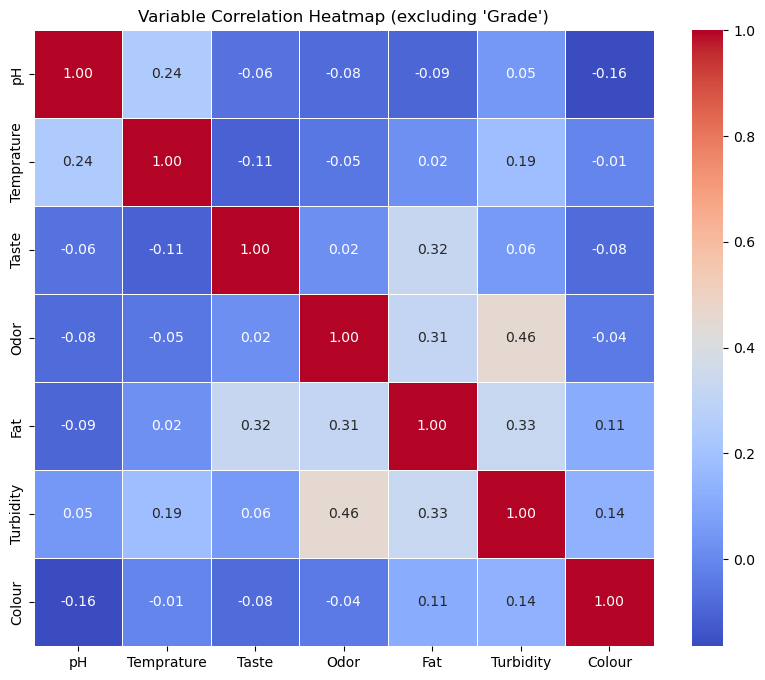

In [10]:
correlation_matrix = df[columns_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

plt.title("Variable Correlation Heatmap (excluding 'Grade')")

plt.show()

In [11]:
X = df[['pH','Temprature','Taste','Odor','Fat','Turbidity','Colour']]
y = df['Grade'] 

# Parameters Standardization

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X

array([[-0.02153136, -0.91410734,  0.91050291, ...,  0.69960809,
        -0.98221664,  0.5016002 ],
       [-0.02153136, -0.81503461, -1.09829413, ..., -1.4293717 ,
         1.01810533,  0.26933321],
       [ 1.33656414,  2.55343832,  0.91050291, ...,  0.69960809,
         1.01810533, -1.35653574],
       ...,
       [-2.59476494, -0.41874368,  0.91050291, ...,  0.69960809,
         1.01810533,  0.73386719],
       [ 0.12142606, -0.12152548,  0.91050291, ...,  0.69960809,
        -0.98221664, -0.42746777],
       [ 1.40804285,  1.06734732, -1.09829413, ...,  0.69960809,
         1.01810533,  0.73386719]])

# Applying K-fold to Training and Test

## Decision-Tree & Linear Discriminant Analysis

In [13]:
model_dt = DecisionTreeClassifier(random_state=42)
model_lda = LinearDiscriminantAnalysis()

In [14]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

dt_fold_accuracies = []
lda_fold_accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_dt.fit(X_train, y_train)
    dt_y_pred = model_dt.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_y_pred)
    dt_fold_accuracies.append(dt_accuracy)
    
    model_lda.fit(X_train, y_train)
    lda_y_pred = model_lda.predict(X_test)
    lda_accuracy = accuracy_score(y_test, lda_y_pred)
    lda_fold_accuracies.append(lda_accuracy)

print(dt_fold_accuracies)
print(lda_fold_accuracies)

[0.9952830188679245, 1.0, 0.9952830188679245, 0.9952830188679245, 0.990521327014218]
[0.7216981132075472, 0.7877358490566038, 0.7594339622641509, 0.7405660377358491, 0.7298578199052133]


# Visualization(part1)

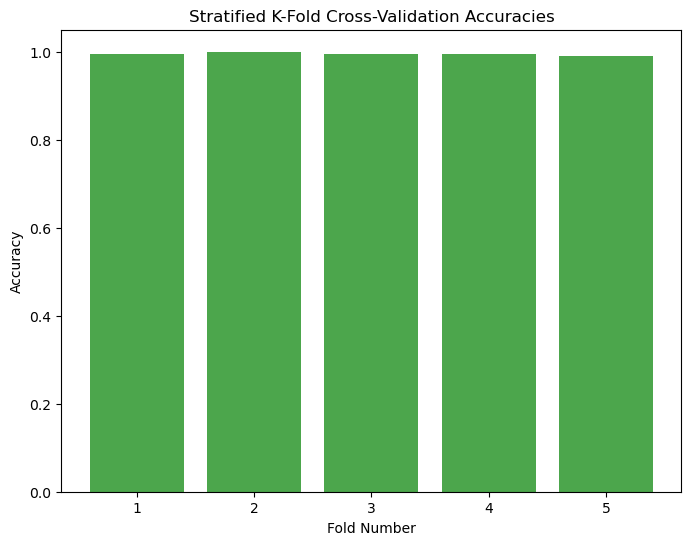

In [15]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, k + 1), dt_fold_accuracies, color='green', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Stratified K-Fold Cross-Validation Accuracies')
plt.show()

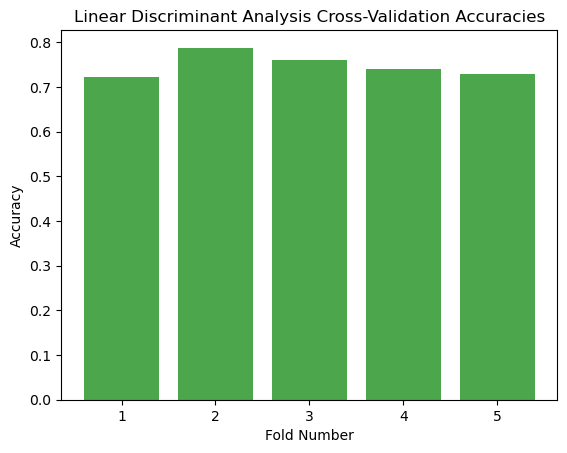

In [16]:
plt.bar(np.arange(1, k + 1), lda_fold_accuracies, color='green', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Linear Discriminant Analysis Cross-Validation Accuracies')
plt.show()

## Logistic Regression & Random Forest Analysis

In [21]:
model_lr = LogisticRegression(random_state=42)
model_rf = RandomForestClassifier(random_state=42)

### do it with k-fold

In [22]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store accuracies of each fold
lr_fold_accuracies = []
rf_fold_accuracies = []

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    # Splitting the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Training and evaluating Logistic Regression
    model_lr.fit(X_train, y_train)
    lr_y_pred = model_lr.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_y_pred)
    lr_fold_accuracies.append(lr_accuracy)
    
    # Training and evaluating Random Forest
    model_rf.fit(X_train, y_train)
    rf_y_pred = model_rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_fold_accuracies.append(rf_accuracy)

# Printing the results
print(lr_fold_accuracies)
print(rf_fold_accuracies)


[0.8537735849056604, 0.8679245283018868, 0.8726415094339622, 0.839622641509434, 0.8246445497630331]
[0.9952830188679245, 1.0, 0.9952830188679245, 1.0, 1.0]


## Tunning the parameters

Define the parameter grid to search

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [28]:
model_rf = RandomForestClassifier(random_state=42)


k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=skf, scoring='accuracy')

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9981132075471699


# Visualization(part2)

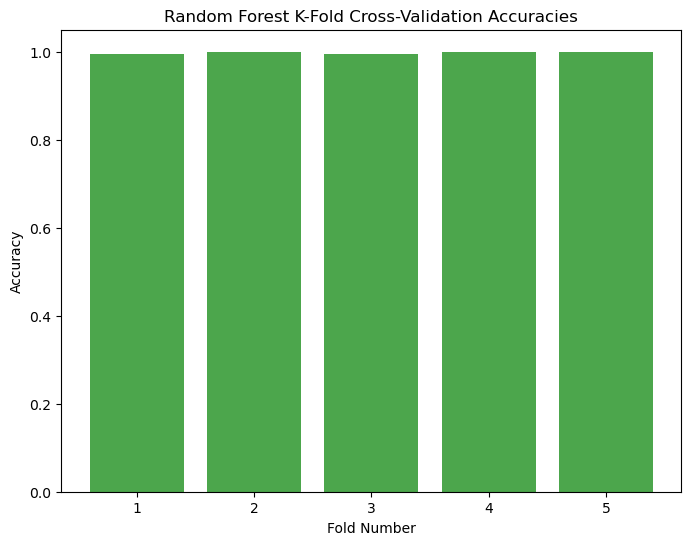

In [32]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, k + 1), rf_fold_accuracies, color='green', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Random Forest K-Fold Cross-Validation Accuracies')
plt.show()

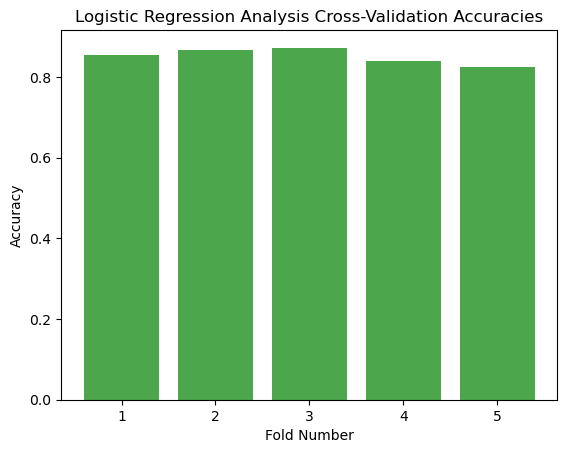

In [31]:
plt.bar(np.arange(1, k + 1), lr_fold_accuracies, color='green', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Analysis Cross-Validation Accuracies')
plt.show()

### create tunning result demostration graph

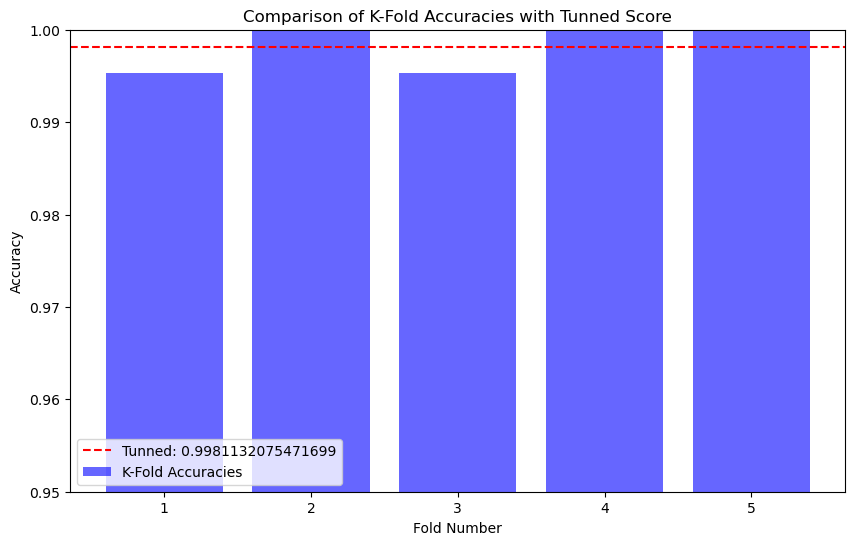

In [35]:
k = len(rf_fold_accuracies)

plt.figure(figsize=(10, 6))

plt.bar(range(1, k+1), rf_fold_accuracies, color='blue', alpha=0.6, label='K-Fold Accuracies')

plt.axhline(y=best_score, color='r', linestyle='--', label=f'Tunned: {best_score}')

plt.ylim(0.95, 1)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Comparison of K-Fold Accuracies with Tunned Score')
plt.xticks(range(1, k+1))  

plt.legend()

plt.show()

### do it with LOOCV

In [23]:
model_lr_1 = LogisticRegression(random_state=42)
model_rf_1 = RandomForestClassifier(random_state=42)

In [25]:
loo = LeaveOneOut()


lr_accuracies_1 = []
rf_accuracies_1 = []


for train_index, test_index in loo.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    model_lr_1.fit(X_train, y_train)
    lr_y_pred = model_lr_1.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_y_pred)
    lr_accuracies_1.append(lr_accuracy)
    

    model_rf_1.fit(X_train, y_train)
    rf_y_pred = model_rf_1.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_accuracies_1.append(rf_accuracy)

lr_overall_accuracy = sum(lr_accuracies_1) / len(lr_accuracies_1)
rf_overall_accuracy = sum(rf_accuracies_1) / len(rf_accuracies_1)

print(f"Logistic Regression LOOCV Accuracy: {lr_overall_accuracy}")
print(f"Random Forest LOOCV Accuracy: {rf_overall_accuracy}")

Logistic Regression LOOCV Accuracy: 0.8508026440037771
Random Forest LOOCV Accuracy: 0.9981114258734656


Since LOOCV is more time consuming in terms of computation than K-fold in nature(LOOCV computes N times for training, we will not do tuning with it.)